# Test: Multiple Counties
* Find where providers don't have service in several counties before applying functions to the entire state.

In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
import utilities
from calitp import *
from shared_utils import geography_utils

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
ca_counties = utilities.get_counties()

In [3]:
# Replace spaces with _ 
ca_counties['county_name'] = ca_counties['county_name'].str.replace(' ','_')

In [4]:
counties_wanted = ['San_Francisco','Los_Angeles','San_Mateo', 'Mariposa']

In [5]:
# Subset to a few counties
# ca_subset = ca_counties[ca_counties["county_name"].isin(counties_wanted)]

In [6]:
# Read in ATT
att = dg.read_parquet("ATT.parquet")

## Go through several counties

In [21]:
def find_difference_and_clip(
    gdf: dg.GeoDataFrame, boundary: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    # Clip cell provider to some boundary
    clipped = dg.clip(gdf, boundary).reset_index(drop=True)  # use dask to clip
    clipped_gdf = clipped.compute()  # compute converts from dask gdf to gdf

    # Now find the overlay, and find the difference
    # Notice which df is on the left and which is on the right
    # https://geopandas.org/en/stable/docs/user_guide/set_operations.html
    no_coverage = gpd.overlay(boundary, clipped_gdf, how="difference",  keep_geom_type=False)

    return no_coverage

In [8]:
def filter_counties():
    # Load geojson with counties 
    counties_df = utilities.get_counties()
    
    # Replace county names of spaces with underscores
    counties_df['county_name'] = counties_df['county_name'].str.replace(' ','_')
    
    # Cast county names to a list
    ca_counties = counties_df.county_name.unique().tolist()
    
    # Filter gdf with all the counties to separate each county into a new df
    # https://stackoverflow.com/questions/64932778/filter-using-a-for-loop-and-return-multiple-data-frames-in-python
    for i in ca_counties:
        # To use the fruit as variable name put it in {} and as the direct value use it straight
        exec(f"{i} = counties_df[counties_df['county_name']== i].reset_index(drop=True)")
    
    # Place all the dataframes into a list 
    # https://stackoverflow.com/questions/2050637/appending-the-same-string-to-a-list-of-strings-in-python
    string = '_df'
    counties_df_list = [x + string for x in ca_counties]

    return counties_df_list

In [13]:
test_list = ca_counties.county_name.unique().tolist()

In [15]:
for i in test_list:
    # To use the fruit as variable name put it in {} and as the direct value use it straight
    exec(f"{i}_df = ca_counties[ca_counties['county_name']== i].reset_index(drop=True)")

In [16]:
string = '_df'
test_df_list = [x + string for x in test_list]

In [17]:
test_df_list

['Alameda_df',
 'Alpine_df',
 'Amador_df',
 'Butte_df',
 'Calaveras_df',
 'Colusa_df',
 'Contra_Costa_df',
 'Del_Norte_df',
 'El_Dorado_df',
 'Fresno_df',
 'Glenn_df',
 'Humboldt_df',
 'Imperial_df',
 'Inyo_df',
 'Kern_df',
 'Kings_df',
 'Lake_df',
 'Lassen_df',
 'Los_Angeles_df',
 'Madera_df',
 'Marin_df',
 'Mariposa_df',
 'Mendocino_df',
 'Merced_df',
 'Modoc_df',
 'Mono_df',
 'Monterey_df',
 'Napa_df',
 'Nevada_df',
 'Orange_df',
 'Placer_df',
 'Plumas_df',
 'Riverside_df',
 'Sacramento_df',
 'San_Benito_df',
 'San_Bernardino_df',
 'San_Diego_df',
 'San_Francisco_df',
 'San_Joaquin_df',
 'San_Luis_Obispo_df',
 'San_Mateo_df',
 'Santa_Barbara_df',
 'Santa_Clara_df',
 'Santa_Cruz_df',
 'Shasta_df',
 'Sierra_df',
 'Siskiyou_df',
 'Solano_df',
 'Sonoma_df',
 'Stanislaus_df',
 'Sutter_df',
 'Tehama_df',
 'Trinity_df',
 'Tulare_df',
 'Tuolumne_df',
 'Ventura_df',
 'Yolo_df',
 'Yuba_df']

In [22]:
att_placer = find_difference_and_clip(att, Placer_df)

<AxesSubplot:>

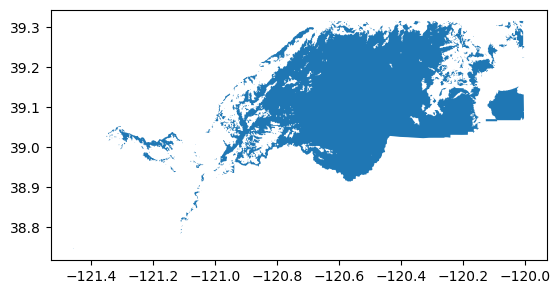

In [25]:
att_placer.plot()

In [26]:
att_sma = find_difference_and_clip(att, San_Mateo_df)

In [27]:
att_sf = find_difference_and_clip(att, San_Francisco_df)

In [28]:
att_mariposa = find_difference_and_clip(att, Mariposa_df)

In [29]:
# https://github.com/cal-itp/data-analyses/blob/main/_shared_utils/shared_utils/gtfs_utils.py#L563-L564
test = dd.multi.concat([att_sma, att_placer, att_sf,att_mariposa], axis=0)

In [30]:
test = test.compute()

In [31]:
type(test)

geopandas.geodataframe.GeoDataFrame

In [32]:
test_dissolved = test.dissolve().drop(columns = 'county_name')

<AxesSubplot:>

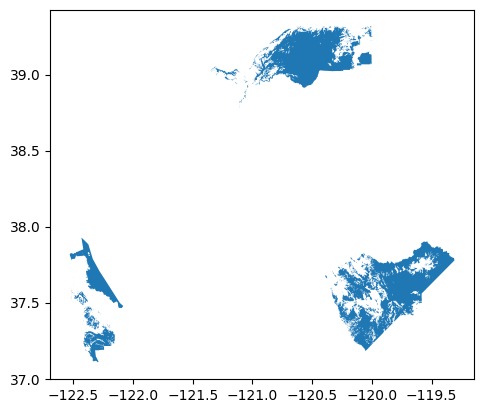

In [33]:
test_dissolved.plot()

In [34]:
routes_df = utilities.load_unique_routes_df()

In [35]:
agency_wanted = [
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Golden Gate Bridge Highway and Transportation District",
    "SamTrans",
    "MUNI",
    "Yosemite Area Regional Transportation System",
]

routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395",
]


def subset_routes(agency_wanted, routes_wanted):
    # Filter out
    routes_subset = routes_df[
        routes_df["route_name"].isin(routes_wanted)
        & routes_df["agency"].isin(agency_wanted)
    ]
    return routes_subset


routes_subset = subset_routes(agency_wanted, routes_wanted)

In [36]:
routes_subset

,itp_id,route_id,geometry,route_name,agency,original_route_length
686,127,705-240,"LINESTRING (-122.26642 37.82804, -122.26642 37...",Oakland - San Francisco,Golden Gate Bridge Highway and Transportation ...,56918.543438
902,171,13054,"LINESTRING (-118.16873 34.06328, -118.16907 34...",Edmund D. Edelman Children’s Court Shuttle,Avocado Heights/Bassett/West Valinda Shuttle,7500.920949
1977,282,14,"LINESTRING (-122.39331 37.79333, -122.39319 37...",24 hour service daily,MUNI,41216.039693
1984,282,22,"LINESTRING (-122.43663 37.80259, -122.43671 37...",24 hour service daily,MUNI,31275.322162
1987,282,25,"LINESTRING (-122.39611 37.79013, -122.39603 37...",24 hour service daily,MUNI,29045.134943
1997,282,38,"LINESTRING (-122.39527 37.78989, -122.39569 37...",24 hour service daily,MUNI,37877.136978
2137,290,251,"LINESTRING (-122.29977 37.53531, -122.29937 37...",Foster City - Hillsdale Mall,SamTrans,104371.495837
2138,290,251-198,"LINESTRING (-122.29977 37.53531, -122.29937 37...",Foster City - Hillsdale Mall,SamTrans,104371.495837
2867,374,582,"LINESTRING (-119.58867 37.74998, -119.58848 37...",Mammoth Lakes HWY 120E/395,Yosemite Area Regional Transportation System,634216.128572


In [37]:
o1 = gpd.overlay(routes_subset, test_dissolved, how="intersection")

In [38]:
o1 = o1.assign(
        overlay_route_length=o1.geometry.to_crs(geography_utils.CA_StatePlane).length
    )

In [39]:
# Calculate the length of the intersected geometry 
o1['percentage_route_length'] = o1['overlay_route_length']/o1['original_route_length']

In [40]:
# Subtract percentage of length to find portion of route that IS covered by provider'
o1['percentage_covered_by_provider'] = 1 - o1['percentage_route_length']

In [41]:
o1

,itp_id,route_id,route_name,agency,original_route_length,geometry,overlay_route_length,percentage_route_length,percentage_covered_by_provider
0,127,705-240,Oakland - San Francisco,Golden Gate Bridge Highway and Transportation ...,56918.543438,"MULTILINESTRING ((-122.34906 37.81930, -122.34...",11944.036970,0.209844,0.790156
1,282,25,24 hour service daily,MUNI,29045.134943,"MULTILINESTRING ((-122.38731 37.78936, -122.38...",8595.526912,0.295937,0.704063
2,374,582,Mammoth Lakes HWY 120E/395,Yosemite Area Regional Transportation System,634216.128572,"MULTILINESTRING ((-119.62221 37.72721, -119.62...",177138.073592,0.279302,0.720698
